<a href="https://colab.research.google.com/github/Ph-Analytic/BADS7105_CRM_ANALYTICS_AND_INTELLIGENCE/blob/Homework-08-%E2%80%93-Campaign-Response-Model/Campaign_Response_Model_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing libraries and datasets**

In [262]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [263]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [264]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [265]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [266]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


In [267]:
df_transactions['day']= df_transactions['trans_date'].dt.day
df_transactions['day']

0         11
1         15
2         26
3         16
4         20
          ..
124995    26
124996    19
124997    28
124998    14
124999    13
Name: day, Length: 125000, dtype: int64

In [268]:
index_names =df_transactions[ (df_transactions['day'] >= 27) ].index
  
# drop these given row
# indexes from dataFrame
df_transactions.drop(index_names, inplace = True)
  
df_transactions

,customer_id,trans_date,tran_amount,day
0,CS5295,2013-02-11,35,11
1,CS4768,2015-03-15,39,15
2,CS2122,2013-02-26,52,26
3,CS1217,2011-11-16,99,16
4,CS1850,2013-11-20,78,20
...,...,...,...,...
124994,CS7809,2012-01-17,55,17
124995,CS8433,2011-06-26,64,26
124996,CS7232,2014-08-19,38,19
124998,CS8133,2013-12-14,13,14


## **Data Preparation**

In [269]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,day,recent
0,CS5295,2013-02-11,35,11,764.0
1,CS4768,2015-03-15,39,15,2.0
2,CS2122,2013-02-26,52,26,749.0
3,CS1217,2011-11-16,99,16,1217.0
4,CS1850,2013-11-20,78,20,482.0


In [270]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [271]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,14,949
1,CS1113,36.0,15,1086
2,CS1114,33.0,14,1021
3,CS1115,12.0,21,1574
4,CS1116,204.0,11,730


In [272]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [273]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,14,949,1309,67.785714
1,CS1113,36.0,15,1086,1295,72.400000
2,CS1114,33.0,14,1021,1309,72.928571
3,CS1115,12.0,21,1574,1303,74.952381
4,CS1116,204.0,11,730,1131,66.363636


## **Calculating response rate**

In [274]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


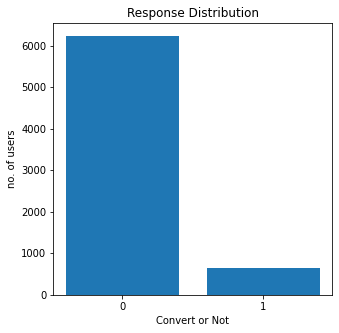

In [275]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [276]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,14,949
1,CS1113,0,36.0,15,1086
2,CS1114,1,33.0,14,1021
3,CS1115,1,12.0,21,1574
4,CS1116,1,204.0,11,730


In [277]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,14,949,1309,67.785714
1,CS1113,0,36.0,15,1086,1295,72.400000
2,CS1114,1,33.0,14,1021,1309,72.928571
3,CS1115,1,12.0,21,1574,1303,74.952381
4,CS1116,1,204.0,11,730,1131,66.363636


## **Creating train and test dataset**

In [278]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [279]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

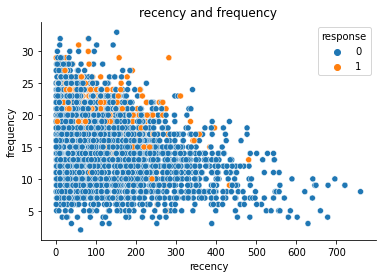

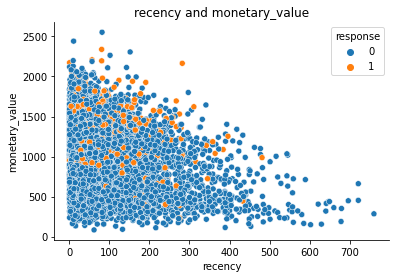

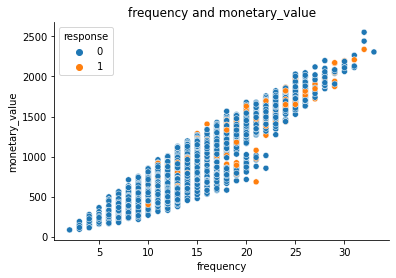

In [280]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

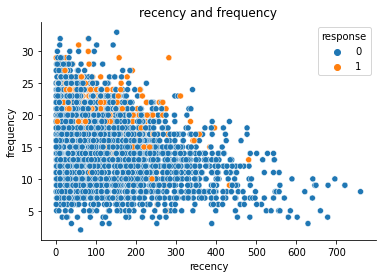

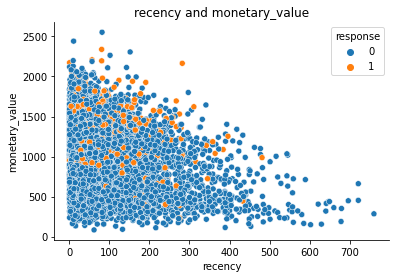

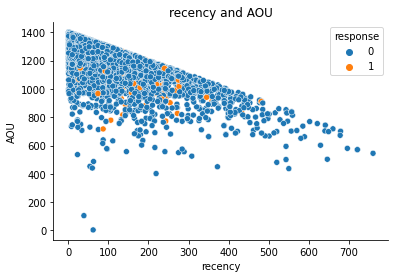

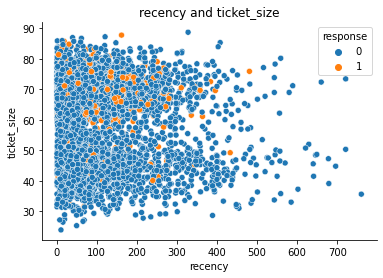

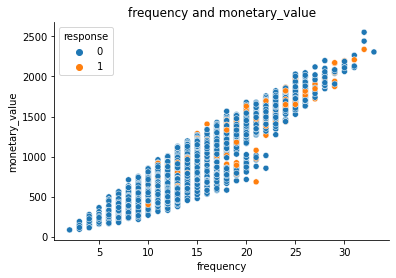

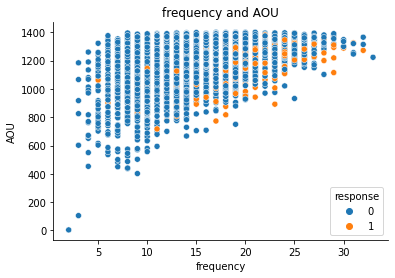

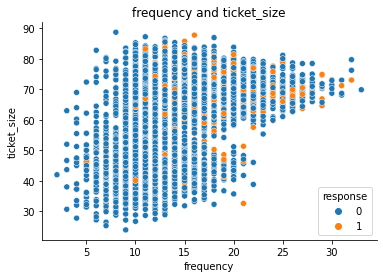

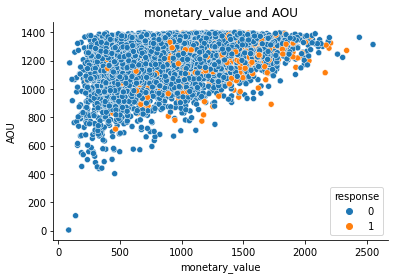

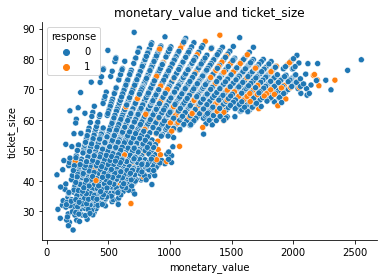

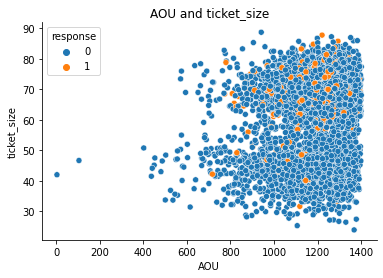

In [281]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [282]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [283]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.67      0.61      0.64      4389
           1       0.64      0.70      0.67      4389

    accuracy                           0.65      8778
   macro avg       0.65      0.65      0.65      8778
weighted avg       0.65      0.65      0.65      8778

test set
              precision    recall  f1-score   support

           0       0.94      0.62      0.75      1848
           1       0.18      0.69      0.28       218

    accuracy                           0.63      2066
   macro avg       0.56      0.66      0.51      2066
weighted avg       0.86      0.63      0.70      2066



In [284]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      4389
           1       0.64      0.69      0.66      4389

    accuracy                           0.65      8778
   macro avg       0.65      0.65      0.65      8778
weighted avg       0.65      0.65      0.65      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.61      0.75      1848
           1       0.18      0.72      0.29       218

    accuracy                           0.63      2066
   macro avg       0.56      0.67      0.52      2066
weighted avg       0.87      0.63      0.70      2066



## **XGBoost**

In [285]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.560224
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.700333
[2]	validation_0-auc:0.700053
[3]	validation_0-auc:0.692407
[4]	validation_0-auc:0.702681
[5]	validation_0-auc:0.709413
[6]	validation_0-auc:0.708559
[7]	validation_0-auc:0.712937
[8]	validation_0-auc:0.710911
[9]	validation_0-auc:0.712599
[10]	validation_0-auc:0.710981
[11]	validation_0-auc:0.711961
[12]	validation_0-auc:0.711013
Stopping. Best iteration:
[7]	validation_0-auc:0.712937

training set
              precision    recall  f1-score   support

           0       0.73      0.55      0.63      4389
           1       0.64      0.80      0.71      4389

    accuracy                           0.67      8778
   macro avg       0.68      0.67      0.67      8778
weighted avg       0.68      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.55      0.70      1848
   

In [286]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.674838
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.70107
[2]	validation_0-auc:0.698296
[3]	validation_0-auc:0.698368
[4]	validation_0-auc:0.698875
[5]	validation_0-auc:0.698368
[6]	validation_0-auc:0.702246
[7]	validation_0-auc:0.70498
[8]	validation_0-auc:0.705672
[9]	validation_0-auc:0.705779
[10]	validation_0-auc:0.705181
[11]	validation_0-auc:0.705062
[12]	validation_0-auc:0.705355
[13]	validation_0-auc:0.704923
[14]	validation_0-auc:0.705417
Stopping. Best iteration:
[9]	validation_0-auc:0.705779

training set
              precision    recall  f1-score   support

           0       0.73      0.54      0.62      4389
           1       0.63      0.80      0.71      4389

    accuracy                           0.67      8778
   macro avg       0.68      0.67      0.66      8778
weighted avg       0.68      0.67      0.66      8778

test set
              precision    recall  f1-score   suppor

In [287]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [288]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score), 'F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.8min finished


In [289]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_clv, predictions)))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.691908112580555
Accuracy: 0.6403678606001936
[[1184  664]
 [  79  139]]
test set
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1848
           1       0.17      0.64      0.27       218

    accuracy                           0.64      2066
   macro avg       0.56      0.64      0.52      2066
weighted avg       0.86      0.64      0.71      2066



In [290]:
#print(xgb_model_SMOTE_clv_GS.best_params_)